<a href="/assets/lecture04_code.ipynb" class="link-button">Download</a>
<a href="https://colab.research.google.com/github/technion046195/technion046195/blob/master/content/lecture05/code.ipynb" target="_blank">
<img src="../assets/colab-badge.svg" style="display:inline"/>
</a>

<center><h1>
הרצאה 5 - Bagging & boosting
</h1></center>

## Setup

In [ ]:
## Importing packages
import os # A build in package for interacting with the OS. For example to create a folder.
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package
import imageio  # A package to read and write image (is used here to save gif images)
import tabulate  # A package from pretty printing tables
from graphviz import Digraph  # A package for plothing graphs (of nodes and edges)

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

## Setting some nice matplotlib defaults
plt.rcParams['figure.figsize'] = (4.5, 4.5)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Auxiliary function for prining equations, pandas tables and images in cells output
from IPython.core.display import display, HTML, Latex, Markdown

## Create output folder
if not os.path.isdir('./output'):
    os.mkdir('./output')

## Credit Card Fraud Detection

In [ ]:
mean_legit = np.array([54, 54])
std_legit = 18
mean_fraud1 = np.array([27, 27])
std_fraud1 = 7.2
# mean_fraud2 = np.array([81, 81])
mean_fraud2 = np.array([27, 27])
std_fraud2 = 7.2

n_legit = 200
n_fraud1 = 25
n_fraud2 = 25

rand_gen = np.random.RandomState(1)

x = np.concatenate((
        rand_gen.randn(n_legit, 2) * std_legit + mean_legit,
        rand_gen.randn(n_fraud1, 2) * std_fraud1 + mean_fraud1,
        rand_gen.randn(n_fraud2, 2) * std_fraud2 + mean_fraud2,
    ), axis=0)

y = np.concatenate((np.ones(n_legit, dtype=int), -np.ones(n_fraud1 + n_fraud2, dtype=int)))

x_grid = np.stack(np.meshgrid(np.linspace(0, 100, 300), np.linspace(0, 100, 300)), axis=2)

In [ ]:
from matplotlib.colors import ListedColormap
def plot_grid_predict(ax, h, x_grid):
    cmap = ListedColormap(plt.cm.tab10([0, 1]))
    grid_predict = h(x_grid.reshape(-1, 2)).reshape(x_grid.shape[:2])
    img_obj = ax.imshow(-grid_predict, extent=[0, 100, 0, 100],
              origin='lower',
              cmap=cmap,
              alpha=0.2,
              interpolation='nearest',
              zorder=-1,
              )
    return img_obj

### Train-Test Split

In [ ]:
n_samples = x.shape[0]

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(1)

## Generating a vector of indices
indices = np.arange(n_samples)

## Shuffle the indices
rand_gen.shuffle(indices)

## Split the indices into 80% train / 20% test
n_samples_train = int(n_samples * 0.8)
train_indices = indices[:n_samples_train]
test_indices = indices[n_samples_train:]

x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]

### The dataset

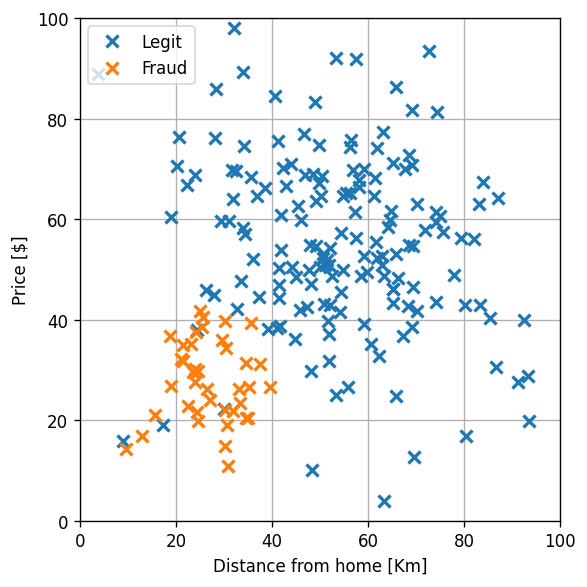

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train[y_train==1, 0], x_train[y_train==1, 1], 'x', label='Legit', ms=7, mew=2)
ax.plot(x_train[y_train==-1, 0], x_train[y_train==-1, 1], 'x', label='Fraud', ms=7, mew=2)
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.tight_layout()
ax.legend(loc='upper left')
# fig.savefig('./output/transactions_dataset.png', dpi=240)

## Boosting

In [ ]:
class stump(object):
    def __init__(self, dim, treshold, flip=False):
        self.dim = dim
        self.treshold = treshold
        self.flip = flip
    
    def __call__(self, x):
        y_hat = (x[:, self.dim] >= self.treshold) * 2 - 1
        if self.flip:
            y_hat = -y_hat
        return y_hat

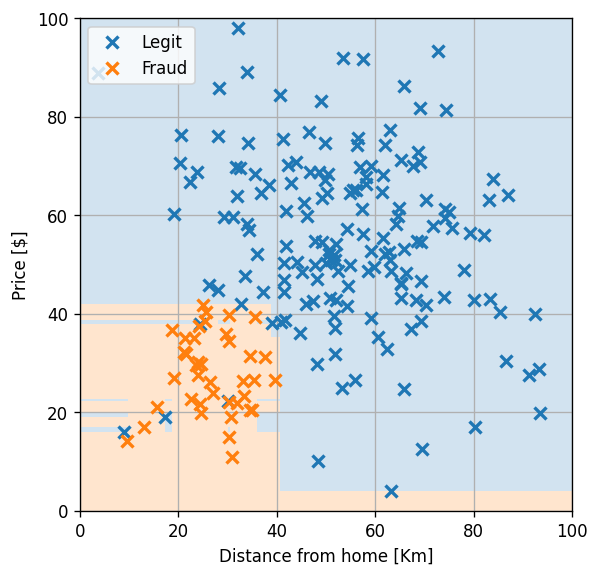

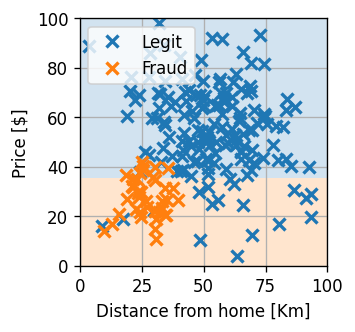

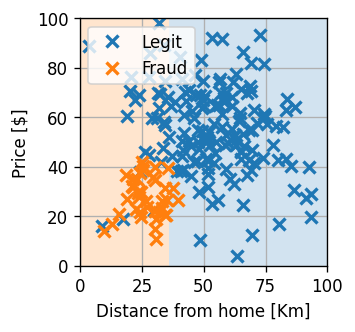

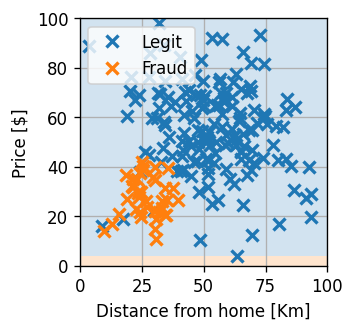

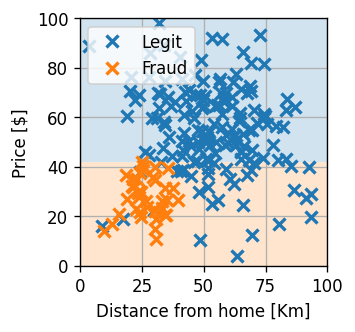

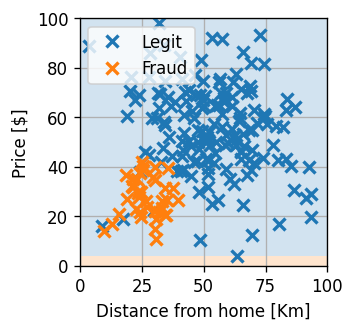

In [ ]:
x = x_train
y = y_train

w = np.ones(x.shape[0])
w /= w.sum()

h_list = []
alpha_list = []

total_score_list = []
bound_list = []

for _ in range(100):
    best_h = None
    best_score = np.inf
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            h = stump(j, x[i, j])
            score = (h(x) != y) @ w
            if score < best_score:
                best_score = score
                best_h = h

            if (1 - score) < best_score:
                best_score = 1 - score
                best_h = stump(j, x[i, j], flip=True)
    
    h = best_h
    score = best_score
    alpha = 0.5 * np.log((1 - score) / score)
    w = w * np.exp(-alpha * y * h(x))
    w /= w.sum()
    
    h_list.append(h)
    alpha_list.append(alpha)
    
    y_hat = np.zeros(x.shape[0])
    bound_term = np.zeros(x.shape[0])
    for h, alpha in zip(h_list, alpha_list):
        y_hat += alpha * h(x)
        bound_term += alpha * y * h(x)
    
    y_hat = np.sign(y_hat)
    total_score = (y_hat != y).mean()
    total_score_list.append(total_score)
    
    bound = np.exp(-bound_term).mean()
    bound_list.append(bound)
    


def h_total(x):
    y_hat = np.zeros(x.shape[0])
    for h, alpha in zip(h_list, alpha_list):
        y_hat += alpha * h(x)
    y_hat = np.sign(y_hat)
    return y_hat

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train[y_train==1, 0], x_train[y_train==1, 1], 'x', label='Legit', ms=7, mew=2)
ax.plot(x_train[y_train==-1, 0], x_train[y_train==-1, 1], 'x', label='Fraud', ms=7, mew=2)
plot_grid_predict(ax, h_total, x_grid)
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.tight_layout()
ax.legend(loc='upper left')


for h in h_list[:5]:
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.plot(x_train[y_train==1, 0], x_train[y_train==1, 1], 'x', label='Legit', ms=7, mew=2)
    ax.plot(x_train[y_train==-1, 0], x_train[y_train==-1, 1], 'x', label='Fraud', ms=7, mew=2)
    plot_grid_predict(ax, h, x_grid)
    ax.set_xlabel('Distance from home [Km]')
    ax.set_ylabel('Price [$]')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    plt.tight_layout()
    ax.legend(loc='upper left')

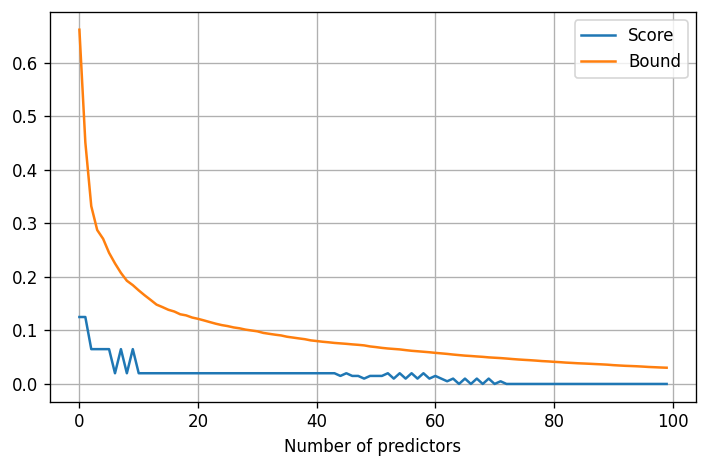

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(total_score_list, label='Score')
ax.plot(bound_list, label='Bound')
ax.set_xlabel('Number of predictors')
# ax.set_ylim(5, 6)
plt.tight_layout()
ax.legend();

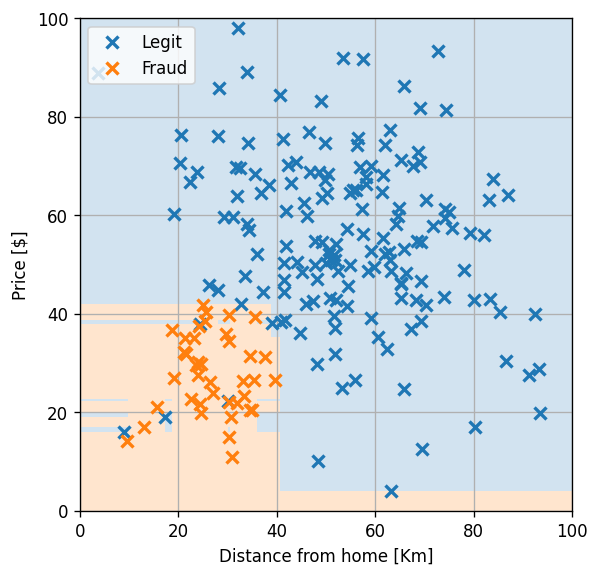

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train[y_train==1, 0], x_train[y_train==1, 1], 'x', label='Legit', ms=7, mew=2)
ax.plot(x_train[y_train==-1, 0], x_train[y_train==-1, 1], 'x', label='Fraud', ms=7, mew=2)
plot_grid_predict(ax, h_total, x_grid)
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.tight_layout()
ax.legend(loc='upper left')